# Data Cleaning and Preparation

Notebook 02 focuses on preparing the incident narratives for modeling. In this stage, we clean and standardize the text fields, apply basic preprocessing routines, and create a new column (description_clean) that will serve as the main input for our NLP workflow. We also define the target labels, split the dataset into training and test sets, and transform the text into numerical features using a TF–IDF vectorizer.

By the end of this notebook, the dataset has a cleaned text field, a reproducible train/test split, and TF–IDF feature matrices ready to be used in the baseline classifier built in the next notebook.

In [12]:
import pandas as pd # For data manipulation
import random
import joblib # For saving/loading models
import sys, os
sys.path.append(os.path.abspath("../src")) # Add src to path
from triage.preprocess import clean_description # For text cleaning
from sklearn.model_selection import train_test_split # For splitting data
from sklearn.feature_extraction.text import TfidfVectorizer # For text vectorization

# Path to generated dataset
df = pd.read_csv("../data/cyber_incidents_simulated.csv")

print(df.head())


   event_id            timestamp     log_source                   event_type  \
0         1  2024-11-10T08:26:19       firewall                      malware   
1         2  2024-07-13T09:48:02           siem                      malware   
2         3  2024-10-17T11:38:15  email_gateway                     phishing   
3         4  2024-12-25T12:44:39       firewall                 access_abuse   
4         5  2024-06-04T05:02:04       firewall  suspicious_network_activity   

   severity mitre_technique  \
0    medium       T1204.002   
1  critical           T1105   
2       low       T1566.002   
3    medium           T1021   
4       low           T1046   

                                        mitre_clause     user  \
0  This activity aligns with MITRE ATT&CK techniq...    leo.v   
1  This activity aligns with MITRE ATT&CK techniq...  karen.b   
2  This activity aligns with MITRE ATT&CK techniq...   eric.m   
3  This activity aligns with MITRE ATT&CK techniq...   eric.m   
4  This

## Text Cleaning and Preparation

In this step, we normalize the primary incident description so it can be reliably vectorized later. The cleaning function converts text to lowercase, replaces URLs with a placeholder token, removes punctuation and standalone numeric tokens, and collapses repeated whitespace. This reduces vocabulary noise and improves downstream TF–IDF feature extraction.

We apply the cleaning function to the `description` column and store the result in `cleaned_description`. This becomes the main modeling input for the baseline classifier introduced in Notebook 03. A preview of original versus cleaned text is shown to verify that preprocessing behaves as intended.

In [13]:
# Apply cleaning to the description column using .loc to avoid chained assignment warnings
df = df.copy()  # Ensure we're working with a copy
df.loc[:, "cleaned_description"] = df["description"].apply(clean_description)

# Display cleaned descriptions
print("Old Descriptions vs Clean Descriptions:")
print(df[["description", "cleaned_description"]].head())

# Create a new text column for modeling using .loc
df.loc[:, "text"] = df["cleaned_description"]

Old Descriptions vs Clean Descriptions:
                                         description  \
0  Based on current evdience that EDR on LINUX-DB...   
1  According to available losg that EDR on WIN10-...   
2  Iintial triage shows that account eric.m repor...   
3  Based on current evidence multiple logins for ...   
4  Initial triage shows commadn-and-control-style...   

                                 cleaned_description  
0  based on current evdience that edr on linux db...  
1  according to available losg that edr on win10 ...  
2  iintial triage shows that account eric m repor...  
3  based on current evidence multiple logins for ...  
4  initial triage shows commadn and control style...  


## Preparing Additional Text Fields (Optional)

Although the baseline model (trained in Notebook 03) only uses the cleaned primary `description` field, the dataset also includes supplemental narratives such as user-reported observations, short system logs, and MITRE ATT&CK context. These fields provide additional linguistic signals and may be useful for future experiments.

**Additional cleaned fields:**
- `description_user_report` → `cleaned_user_report`: User-submitted incident descriptions
- `short_log` → `cleaned_short_log`: Brief system log excerpts
- `mitre_clause` → `cleaned_mitre_clause`: MITRE ATT&CK tactic descriptions
- `mitre_technique` → `cleaned_mitre_technique`: MITRE technique IDs (e.g., T1059.001)

**Combined text representation:**
We also create `text_combined`, which merges all cleaned fields into a single unified representation. This combined text is **not used in the baseline model** (which focuses on description-only for simplicity), but provides flexibility for later modeling stages such as:
- Multi-field TF-IDF approaches
- Transformer-based encoders that benefit from richer context
- Hybrid models combining text with structured features (severity, log_source, MITRE mappings)

This preparation step ensures that all text fields are properly cleaned and ready for experimentation without requiring re-preprocessing.

In [14]:
# --- 1. Clean supplemental text fields using .loc ---

df.loc[:, "cleaned_user_report"] = (
    df["description_user_report"]
    .fillna("")
    .astype(str)
    .apply(clean_description)
)

df.loc[:, "cleaned_short_log"] = (
    df["short_log"]
    .fillna("")
    .astype(str)
    .apply(clean_description)
)

# --- 2. Clean MITRE clause and MITRE technique fields ---

df.loc[:, "cleaned_mitre_clause"] = (
    df["mitre_clause"]
    .fillna("")
    .astype(str)
    .apply(clean_description)
)

df.loc[:, "cleaned_mitre_technique"] = (
    df["mitre_technique"]
    .fillna("")
    .astype(str)
    # Mitre IDs like "T1059.001" lose the dot if cleaned too aggressively,
    # so we normalize BEFORE passing into clean_description.
    .str.replace(".", " ", regex=False)
    .apply(clean_description)
)

# --- 3. Combine ALL cleaned fields into unified training text ---

df.loc[:, "text_combined"] = (
    df["cleaned_description"] + " "
    + df["cleaned_user_report"] + " "
    + df["cleaned_short_log"] + " "
    + df["cleaned_mitre_clause"] + " "
    + df["cleaned_mitre_technique"]
).str.strip()

# --- 4. Inspect the output ---
print(df[[
    "description",
    "description_user_report",
    "short_log",
    "mitre_clause",
    "mitre_technique",
    "text_combined"
]].head())

                                         description  \
0  Based on current evdience that EDR on LINUX-DB...   
1  According to available losg that EDR on WIN10-...   
2  Iintial triage shows that account eric.m repor...   
3  Based on current evidence multiple logins for ...   
4  Initial triage shows commadn-and-control-style...   

                             description_user_report  \
0  leo.v flagged that files on LINUX-DB-01 sudden...   
1  karen.b alerted about that WIN10-LAPTOP-02 was...   
2  eric.m reported receiving an email about accou...   
3  eric.m flagged receiving alerts about sign-ins...   
4  No direct user report; discovered through auto...   

                                           short_log  \
0  MALWARE on LINUX-DB-01 from 23.152.109.9 to 8....   
1  MALWARE on WIN10-LAPTOP-02 from 175.227.138.19...   
2  PHISHING on MACBOOK-SEC-01 from 179.246.188.20...   
3  ACCESS_ABUSE on SRV-APP-01 from 231.239.204.24...   
4  SUSPICIOUS_NETWORK_ACTIVITY on SRV-FILE-01 

In [15]:
# Define features
X_text = df["text"]

X = df["text"]
y = df["event_type"]

X_text.head(), y.head()  # Display first few entries

(0    based on current evdience that edr on linux db...
 1    according to available losg that edr on win10 ...
 2    iintial triage shows that account eric m repor...
 3    based on current evidence multiple logins for ...
 4    initial triage shows commadn and control style...
 Name: text, dtype: object,
 0                        malware
 1                        malware
 2                       phishing
 3                   access_abuse
 4    suspicious_network_activity
 Name: event_type, dtype: object)

In [16]:
# Train-test split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["text"], 
    df["event_type"], 
    test_size=0.3, 
    random_state=42, 
    stratify=df["event_type"]
)
print(f"Training samples: {len(X_train_text)}, Testing samples: {len(X_test_text)}")

Training samples: 350000, Testing samples: 150000


## TF–IDF Vectorization

In this step, the text descriptions are transformed into numerical features using TF–IDF (Term Frequency–Inverse Document Frequency). This representation highlights terms that are informative for distinguishing between event types while reducing the influence of extremely common or uninformative words.

**Vectorization parameters:**
- **ngram_range=(1, 2)**: Captures both single words (unigrams) and two-word phrases (bigrams)
- **min_df=3**: Ignores terms appearing in fewer than 3 documents (removes rare/noisy terms)
- **max_df=0.95**: Ignores terms appearing in >95% of documents (removes overly common words)
- **max_features=5000**: Limits vocabulary to top 5000 most informative features
- **stop_words="english"**: Removes common English words (the, a, is, etc.)
- **token_pattern**: Only includes tokens starting with a letter (filters pure numbers)

**Feature analysis:**
The resulting TF-IDF matrix is sparse (typically >99% zeros), meaning most documents contain only a small fraction of the total vocabulary. This is expected and efficient for NLP tasks. The visualizations below show:
- **Sparsity metrics**: Percentage of zero-valued features in the matrix
- **Average TF-IDF distributions**: Shows how feature importance is distributed across documents
- **Vocabulary composition**: Breakdown of unigrams vs bigrams in the final feature set

These visualizations confirm that the vectorizer produces a compact, discriminative representation suitable for classification.

In [17]:
# TF–IDF Vectorization
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2), # Unigrams and bigrams
    min_df=3, # Ignore terms that appear in less than 3 documents
    max_df=0.95, # Ignore terms that appear in more than 95% of documents
    max_features=5000, # Limit to top 5000 features
    stop_words="english", # Remove English stop words
    token_pattern=r"(?u)\b[a-z][a-z0-9]+\b" # Only keep tokens that start with a letter and are followed by letters/numbers
)

X_train = vectorizer.fit_transform(X_train_text) # Fit on training data
X_test = vectorizer.transform(X_test_text) # Transform test data

print(f"TF–IDF feature matrix shape: {X_train.shape}, {X_test.shape}") # Display shape of feature matrices
print(f"\nSample feature names: {vectorizer.get_feature_names_out()[:10]}") # Display sample feature names
print(f"\nSample TF–IDF values (first document): {X_train[0].toarray()[0][:10]}") # Display sample TF–IDF values for the first document
print(f"\nTotal unique features: {len(vectorizer.get_feature_names_out())}") # Display total number of unique features

print("\n--- TF–IDF Feature Exploration ---")

# See non-zero features for the first document
row = X_train[0]
nonzero_idx = row.nonzero()[1]
nonzero_vals = row.toarray()[0][nonzero_idx]

print("\nFirst 10 non-zero TF–IDF features for the first document:")
for idx, val in list(zip(nonzero_idx, nonzero_vals))[:10]: # Display first 10 non-zero features
    print(f"{vectorizer.get_feature_names_out()[idx]} -> {val:.4f}") # Display feature name and value


TF–IDF feature matrix shape: (350000, 5000), (150000, 5000)

Sample feature names: ['aaginst' 'aanlysis' 'aanlysis indicates' 'aanlysis reveals' 'aavilable'
 'aavilable logs' 'abnormal' 'abnormal smb' 'ac' 'accept']

Sample TF–IDF values (first document): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Total unique features: 5000

--- TF–IDF Feature Exploration ---

First 10 non-zero TF–IDF features for the first document:
initial -> 0.0476
asesssment -> 0.1411
suggests -> 0.0674
susipcious -> 0.1194
authentication -> 0.1382
activity -> 0.0392
leo -> 0.0966
usr -> 0.0776
accepted -> 0.1896
mfa -> 0.2305


## Sentence Embeddings for Semantic Features

While TF-IDF captures word importance through statistical patterns, it misses semantic relationships between words. For example, "phishing email" and "credential harvesting attempt" may have zero overlap in TF-IDF space despite describing similar threats.

**Sentence embeddings** solve this by encoding entire incident descriptions into dense semantic vectors using a pre-trained transformer model (all-MiniLM-L6-v2). This captures:
- **Semantic similarity**: Incidents with different words but similar meaning cluster together
- **Contextual understanding**: Phrases like "suspicious attachment" and "malicious payload" are semantically close
- **Cross-domain knowledge**: The model was trained on diverse text, so it understands security terminology

**Why combine TF-IDF + Embeddings?**
- **TF-IDF**: Excellent at capturing specific keywords and term frequencies (e.g., "ransomware", "exfiltration")
- **Embeddings**: Excellent at capturing semantic meaning and context (e.g., understanding intent, threat patterns)
- **Fusion**: The combination captures both explicit keywords AND semantic patterns, improving:
  - Phishing detection (similar social engineering tactics)
  - Insider threat differentiation (subtle behavioral patterns)
  - Ambiguous borderline cases (semantic context resolves uncertainty)

This hybrid approach is a well-known powerful pattern in NLP that consistently outperforms either method alone.

In [18]:
# Reload embeddings module to get latest changes
import importlib
import triage.embeddings
importlib.reload(triage.embeddings)
from triage.embeddings import get_embedder

import numpy as np
from scipy.sparse import hstack, csr_matrix

print("Loading sentence transformer model (all-MiniLM-L6-v2)...")
embedder = get_embedder()
print(f"✓ Model loaded successfully")

# Generate sentence embeddings for training set
print(f"\nEncoding {len(X_train_text)} training incidents...")
train_embeddings = embedder.encode(X_train_text.tolist(), normalize=True)
print(f"✓ Training embeddings shape: {train_embeddings.shape}")

# Generate sentence embeddings for test set
print(f"\nEncoding {len(X_test_text)} test incidents...")
test_embeddings = embedder.encode(X_test_text.tolist(), normalize=True)
print(f"✓ Test embeddings shape: {test_embeddings.shape}")

print("\n--- Embedding Statistics ---")
print(f"Embedding dimensions: {train_embeddings.shape[1]}")
print(f"Mean embedding norm (train): {np.linalg.norm(train_embeddings, axis=1).mean():.4f}")
print(f"Mean embedding norm (test): {np.linalg.norm(test_embeddings, axis=1).mean():.4f}")

# Preview first embedding
print(f"\nFirst training embedding (first 10 values):")
print(train_embeddings[0][:10])

Loading sentence transformer model (all-MiniLM-L6-v2)...
✓ Model loaded successfully

Encoding 350000 training incidents...


Batches:   0%|          | 0/10938 [00:00<?, ?it/s]

✓ Training embeddings shape: (350000, 384)

Encoding 150000 test incidents...


Batches:   0%|          | 0/4688 [00:00<?, ?it/s]

✓ Test embeddings shape: (150000, 384)

--- Embedding Statistics ---
Embedding dimensions: 384
Mean embedding norm (train): 1.0000
Mean embedding norm (test): 1.0000

First training embedding (first 10 values):
[-0.13861664  0.02598734 -0.00376551 -0.1159482   0.07684256 -0.03382845
  0.04738731 -0.04853443  0.04247413 -0.0335996 ]


## Feature Fusion: TF-IDF + Embeddings + Structured Features

Now we combine three complementary feature types into a unified representation:

1. **TF-IDF features** (5000 dimensions): Sparse, keyword-focused, captures specific terms
2. **Sentence embeddings** (384 dimensions): Dense, semantic-focused, captures meaning
3. **Structured features** (optional): Categorical encodings (severity, source, etc.)

**Fusion strategy:**
```
combined_vector = concat(tfidf_vector, embedding_vector, structured_features)
```

This creates a powerful hybrid representation where:
- Keywords like "ransomware" trigger via TF-IDF
- Semantic patterns like "unauthorized access" + "sensitive data" trigger via embeddings
- Metadata like high severity + external source provides additional context

The resulting feature matrix has ~5384 dimensions (5000 TF-IDF + 384 embeddings), which logistic regression handles efficiently thanks to sparsity in the TF-IDF component.

In [19]:
# Convert dense embeddings to sparse format for efficient concatenation
train_embeddings_sparse = csr_matrix(train_embeddings)
test_embeddings_sparse = csr_matrix(test_embeddings)

# Combine TF-IDF + Sentence Embeddings
X_train_combined = hstack([X_train, train_embeddings_sparse])
X_test_combined = hstack([X_test, test_embeddings_sparse])

print("--- Feature Fusion Results ---")
print(f"\nOriginal TF-IDF shape:")
print(f"  Training: {X_train.shape}")
print(f"  Test: {X_test.shape}")

print(f"\nSentence embedding shape:")
print(f"  Training: {train_embeddings.shape}")
print(f"  Test: {test_embeddings.shape}")

print(f"\n✓ Combined feature matrix shape:")
print(f"  Training: {X_train_combined.shape} ({X_train_combined.shape[1]} total features)")
print(f"  Test: {X_test_combined.shape} ({X_test_combined.shape[1]} total features)")

print(f"\nFeature breakdown:")
print(f"  - TF-IDF features: {X_train.shape[1]} (sparse)")
print(f"  - Embedding features: {train_embeddings.shape[1]} (dense → sparse)")
print(f"  - Total: {X_train_combined.shape[1]}")

# Check sparsity of combined matrix
sparsity_combined = 1.0 - (X_train_combined.nnz / (X_train_combined.shape[0] * X_train_combined.shape[1]))
print(f"\nCombined matrix sparsity: {sparsity_combined:.4f} ({sparsity_combined*100:.2f}% zeros)")
print(f"Memory efficient: Still mostly sparse thanks to TF-IDF dominance")

--- Feature Fusion Results ---

Original TF-IDF shape:
  Training: (350000, 5000)
  Test: (150000, 5000)

Sentence embedding shape:
  Training: (350000, 384)
  Test: (150000, 384)

✓ Combined feature matrix shape:
  Training: (350000, 5384) (5384 total features)
  Test: (150000, 5384) (5384 total features)

Feature breakdown:
  - TF-IDF features: 5000 (sparse)
  - Embedding features: 384 (dense → sparse)
  - Total: 5384

Combined matrix sparsity: 0.9147 (91.47% zeros)
Memory efficient: Still mostly sparse thanks to TF-IDF dominance


## Visualizing Embedding Space

To verify that sentence embeddings capture meaningful semantic patterns, we'll visualize them in 2D using PCA (Principal Component Analysis). Incidents of the same class should cluster together if the embeddings encode discriminative semantic features.

**What to look for:**
- **Tight clusters**: Incidents of the same type group together (e.g., all phishing incidents)
- **Clear separation**: Different incident types occupy distinct regions of embedding space
- **Semantic proximity**: Similar threat types (e.g., malware vs ransomware) should be closer than dissimilar types (e.g., malware vs DDoS)

This visualization confirms that sentence embeddings provide complementary signal to TF-IDF for classification.

Reducing 384D embeddings to 2D for visualization...
✓ PCA variance explained: 19.80%
  - PC1: 11.30%
  - PC2: 8.50%


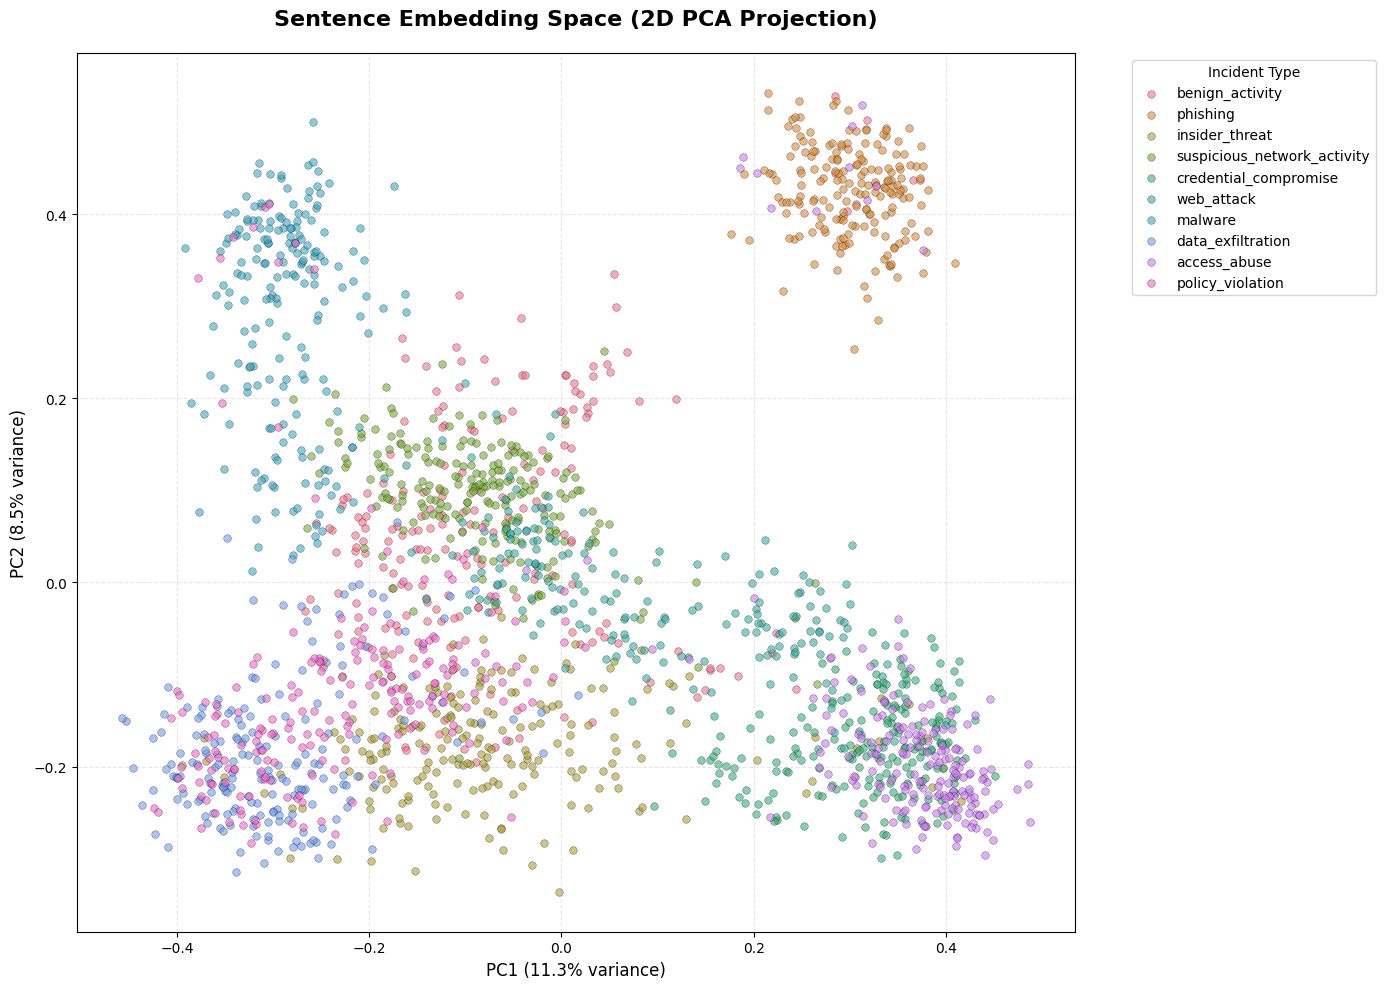


✓ Visualization complete!
Each point represents one incident's semantic embedding.
Proximity indicates semantic similarity (not just keyword overlap).


In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Sample 2000 points for visualization (full dataset would be cluttered)
sample_size = min(2000, len(train_embeddings))
sample_indices = np.random.choice(len(train_embeddings), sample_size, replace=False)

embeddings_sample = train_embeddings[sample_indices]
labels_sample = y_train.iloc[sample_indices]

# Reduce to 2D using PCA
print(f"Reducing {embeddings_sample.shape[1]}D embeddings to 2D for visualization...")
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings_sample)

print(f"✓ PCA variance explained: {pca.explained_variance_ratio_.sum():.2%}")
print(f"  - PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"  - PC2: {pca.explained_variance_ratio_[1]:.2%}")

# Create visualization
plt.figure(figsize=(14, 10))

# Get unique classes and assign colors
unique_classes = labels_sample.unique()
colors = sns.color_palette("husl", len(unique_classes))
class_to_color = dict(zip(unique_classes, colors))

# Plot each class
for class_label in unique_classes:
    mask = labels_sample == class_label
    plt.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        c=[class_to_color[class_label]],
        label=class_label,
        alpha=0.6,
        s=30,
        edgecolors='black',
        linewidth=0.3
    )

plt.title("Sentence Embedding Space (2D PCA Projection)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)", fontsize=12)
plt.legend(title="Incident Type", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")
print(f"Each point represents one incident's semantic embedding.")
print(f"Proximity indicates semantic similarity (not just keyword overlap).")


--- TF-IDF Feature Sparsity Analysis ---
Training set sparsity: 0.9850 (98.50% zeros)
Test set sparsity: 0.9850 (98.50% zeros)


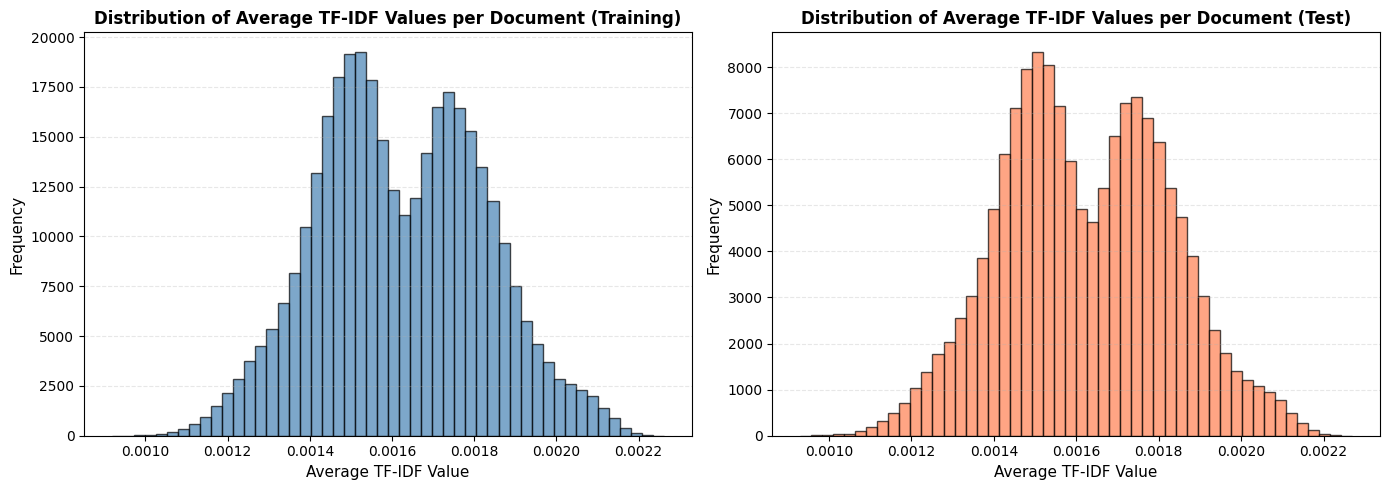


--- Vocabulary Composition Analysis ---
Total features: 5000
Unigrams: 1837 (36.7%)
Bigrams: 3163 (63.3%)


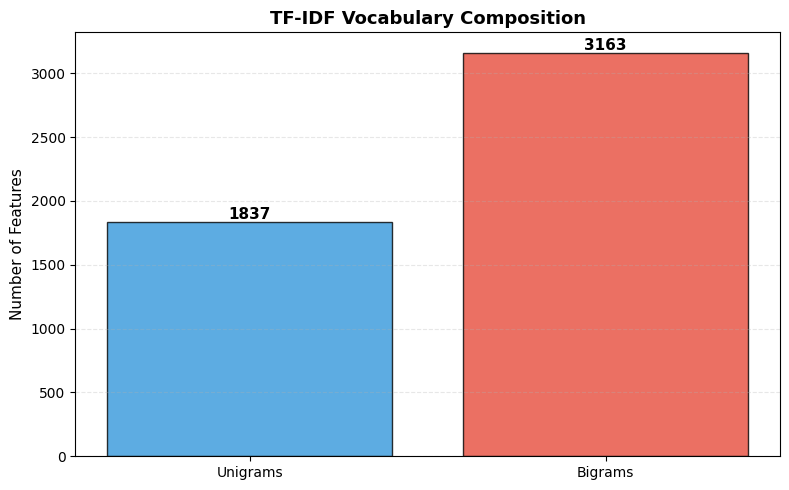

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plot style
plt.style.use("default")
sns.set_palette("husl")

# Visualize TF-IDF feature distribution
print("\n--- TF-IDF Feature Sparsity Analysis ---")
sparsity_train = 1.0 - (X_train.nnz / (X_train.shape[0] * X_train.shape[1]))
sparsity_test = 1.0 - (X_test.nnz / (X_test.shape[0] * X_test.shape[1]))
print(f"Training set sparsity: {sparsity_train:.4f} ({sparsity_train*100:.2f}% zeros)")
print(f"Test set sparsity: {sparsity_test:.4f} ({sparsity_test*100:.2f}% zeros)")

# Plot average TF-IDF values per document
train_means = np.array(X_train.mean(axis=1)).flatten()
test_means = np.array(X_test.mean(axis=1)).flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(train_means, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_title("Distribution of Average TF-IDF Values per Document (Training)", fontsize=12, fontweight='bold')
ax1.set_xlabel("Average TF-IDF Value", fontsize=11)
ax1.set_ylabel("Frequency", fontsize=11)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

ax2.hist(test_means, bins=50, color='coral', alpha=0.7, edgecolor='black')
ax2.set_title("Distribution of Average TF-IDF Values per Document (Test)", fontsize=12, fontweight='bold')
ax2.set_xlabel("Average TF-IDF Value", fontsize=11)
ax2.set_ylabel("Frequency", fontsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Visualize vocabulary size across different feature types
print("\n--- Vocabulary Composition Analysis ---")
feature_names = vectorizer.get_feature_names_out()
unigrams = [f for f in feature_names if ' ' not in f]
bigrams = [f for f in feature_names if ' ' in f]

print(f"Total features: {len(feature_names)}")
print(f"Unigrams: {len(unigrams)} ({len(unigrams)/len(feature_names)*100:.1f}%)")
print(f"Bigrams: {len(bigrams)} ({len(bigrams)/len(feature_names)*100:.1f}%)")

fig, ax = plt.subplots(figsize=(8, 5))
vocab_composition = pd.DataFrame({
    'Type': ['Unigrams', 'Bigrams'],
    'Count': [len(unigrams), len(bigrams)]
})
bars = ax.bar(vocab_composition['Type'], vocab_composition['Count'], color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black')
ax.set_title("TF-IDF Vocabulary Composition", fontsize=13, fontweight='bold')
ax.set_ylabel("Number of Features", fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

In [22]:
# Save processed data and vectorizer for later use
joblib.dump(vectorizer, "../models/vectorizer.joblib")
print("Data preparation complete. Vectorizer saved to '../models/vectorizer.joblib'.")

# Save TF-IDF only features (for baseline comparison)
X_train_file = "../models/X_train_tfidf.joblib"
X_test_file = "../models/X_test_tfidf.joblib"
y_train_file = "../models/y_train.joblib"
y_test_file = "../models/y_test.joblib"

joblib.dump(X_train, X_train_file)
print(f"✓ TF-IDF training features saved to '{X_train_file}'")
joblib.dump(X_test, X_test_file)
print(f"✓ TF-IDF test features saved to '{X_test_file}'")
joblib.dump(y_train, y_train_file)
print(f"✓ Training labels saved to '{y_train_file}'")
joblib.dump(y_test, y_test_file)
print(f"✓ Test labels saved to '{y_test_file}'")

# Save combined features (TF-IDF + Embeddings) for enhanced model
X_train_combined_file = "../models/X_train_combined.joblib"
X_test_combined_file = "../models/X_test_combined.joblib"

joblib.dump(X_train_combined, X_train_combined_file)
print(f"\n✓ Combined training features saved to '{X_train_combined_file}'")
print(f"  Shape: {X_train_combined.shape} (TF-IDF + Embeddings)")

joblib.dump(X_test_combined, X_test_combined_file)
print(f"✓ Combined test features saved to '{X_test_combined_file}'")
print(f"  Shape: {X_test_combined.shape} (TF-IDF + Embeddings)")

# Also save embeddings separately for potential future use
joblib.dump(train_embeddings, "../models/train_embeddings.joblib")
joblib.dump(test_embeddings, "../models/test_embeddings.joblib")
print(f"\n✓ Sentence embeddings saved separately")

print("\n" + "="*60)
print("📦 SAVED ARTIFACTS:")
print("="*60)
print("Baseline (TF-IDF only):")
print(f"  • X_train_tfidf.joblib ({X_train.shape[1]} features)")
print(f"  • X_test_tfidf.joblib ({X_test.shape[1]} features)")
print("\nEnhanced (TF-IDF + Embeddings):")
print(f"  • X_train_combined.joblib ({X_train_combined.shape[1]} features)")
print(f"  • X_test_combined.joblib ({X_test_combined.shape[1]} features)")
print("\nReady for Notebook 03: Model training and comparison!")
print("="*60)

Data preparation complete. Vectorizer saved to '../models/vectorizer.joblib'.
✓ TF-IDF training features saved to '../models/X_train_tfidf.joblib'
✓ TF-IDF test features saved to '../models/X_test_tfidf.joblib'
✓ Training labels saved to '../models/y_train.joblib'
✓ Test labels saved to '../models/y_test.joblib'

✓ Combined training features saved to '../models/X_train_combined.joblib'
  Shape: (350000, 5384) (TF-IDF + Embeddings)
✓ Combined test features saved to '../models/X_test_combined.joblib'
  Shape: (150000, 5384) (TF-IDF + Embeddings)

✓ Sentence embeddings saved separately

📦 SAVED ARTIFACTS:
Baseline (TF-IDF only):
  • X_train_tfidf.joblib (5000 features)
  • X_test_tfidf.joblib (5000 features)

Enhanced (TF-IDF + Embeddings):
  • X_train_combined.joblib (5384 features)
  • X_test_combined.joblib (5384 features)

Ready for Notebook 03: Model training and comparison!
